In this notebook we want to get to know our data better. For this purpose we will perfrom some analysis to gain a better insight into our dataset.

In [2]:
# !nvidia-smi | head
# !lscpu | grep -E "Model|Socket"

In [3]:
# !pip install cudf-cu12 dask-cudf-cu12 cuml-cu12 cugraph-cu12 nx-cugraph-cu12 cuspatial-cu12 cuproj-cu12 cuxfilter-cu12 cucim-cu12 pylibraft-cu12 raft-dask-cu12 cuvs-cu12 --extra-index-url=https://pypi.nvidia.com

In [1]:
import os 

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
import ast

import math

In [2]:
bbox_df = pd.read_csv('./dataset/BBox_List_2017.csv')
data_entry_df = pd.read_csv('./dataset/Data_Entry_2017.csv')


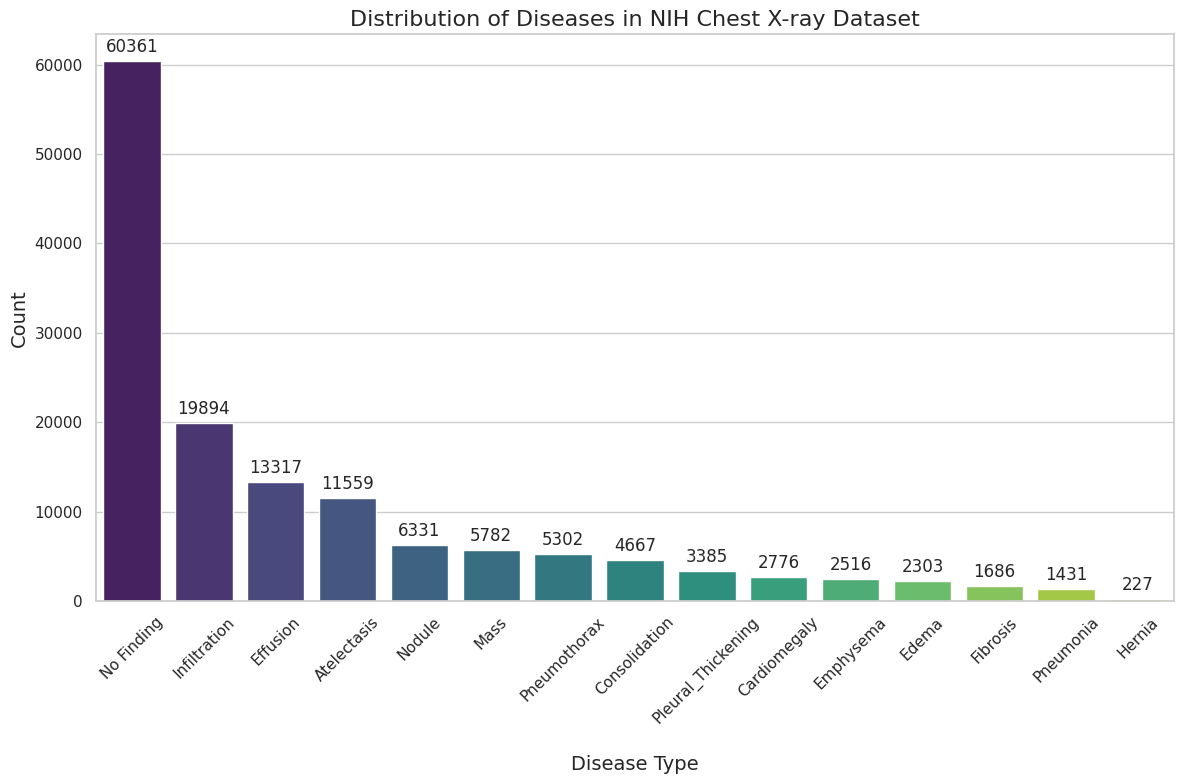

In [49]:
def plotColumnDistribution(df, column, threshold=10):
    # Split multiple findings in the 'Finding Labels' column
    all_labels = df[column].str.split('|').explode()
    
    # Count the occurrences of each disease
    disease_counts = all_labels.value_counts().sort_values(ascending=False)
    
    # Filter out diseases that have occurred less than or equal to the threshold
    disease_counts = disease_counts[disease_counts > threshold]
    
    # Set up the style for scientific visualization
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # Create a bar plot for disease distribution
    ax = sns.barplot(
        x=disease_counts.index, 
        y=disease_counts.values, 
        hue=disease_counts.index, 
        palette="viridis", 
        dodge=False, 
        legend=False
    )

    # Add the actual value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    # Set labels and title
    ax.set_xlabel('Disease Type', fontsize=14, labelpad=20)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title('Distribution of Diseases in NIH Chest X-ray Dataset', fontsize=16)

    # Rotate x labels for better readability and centralize them with respect to bars
    plt.xticks(rotation=45, ha='center')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
plotColumnDistribution(data_entry_df, 'Finding Labels', threshold=100)

CPU times: user 23 ms, sys: 1.58 ms, total: 24.6 ms
Wall time: 24.1 ms


In [57]:
# Ensure that all columns have supported types by cudf
data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].astype('str')

# Remove columns that have "Unnamed" in their names
data_entry_df = data_entry_df.loc[:, ~data_entry_df.columns.str.contains('^Unnamed')]

# Split the 'Finding Labels' column into a list of labels
data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].str.split('|')

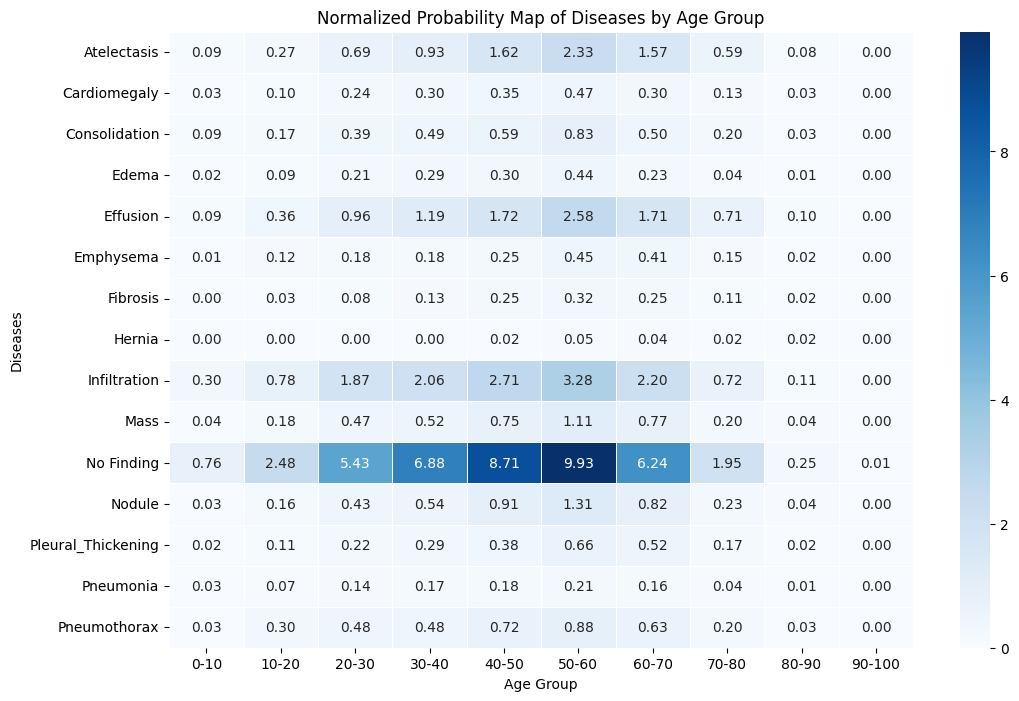

In [56]:
# Define age bins and labels
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Get the list of all unique diseases
diseases = sorted(set([disease for sublist in data_entry_df['Finding Labels'] for disease in sublist]))

# Calculate the count of each disease in each age bin
disease_count_matrix = pd.DataFrame(0, index=age_labels, columns=diseases)

for i in range(1, len(age_bins)):
    age_range_df = data_entry_df[data_entry_df['Patient Age'].between(age_bins[i-1], age_bins[i], inclusive="right")]
    bin_disease_count = age_range_df['Finding Labels'].explode().value_counts().reindex(diseases, fill_value=0)
    disease_count_matrix.loc[age_labels[i-1]] = bin_disease_count

# Normalize the count matrix over all elements (global normalization)
normalized_map = disease_count_matrix / disease_count_matrix.values.sum() * 100

# Plot the normalized probability matrix
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_map.T, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Normalized Probability Map of Diseases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Diseases')
plt.show()


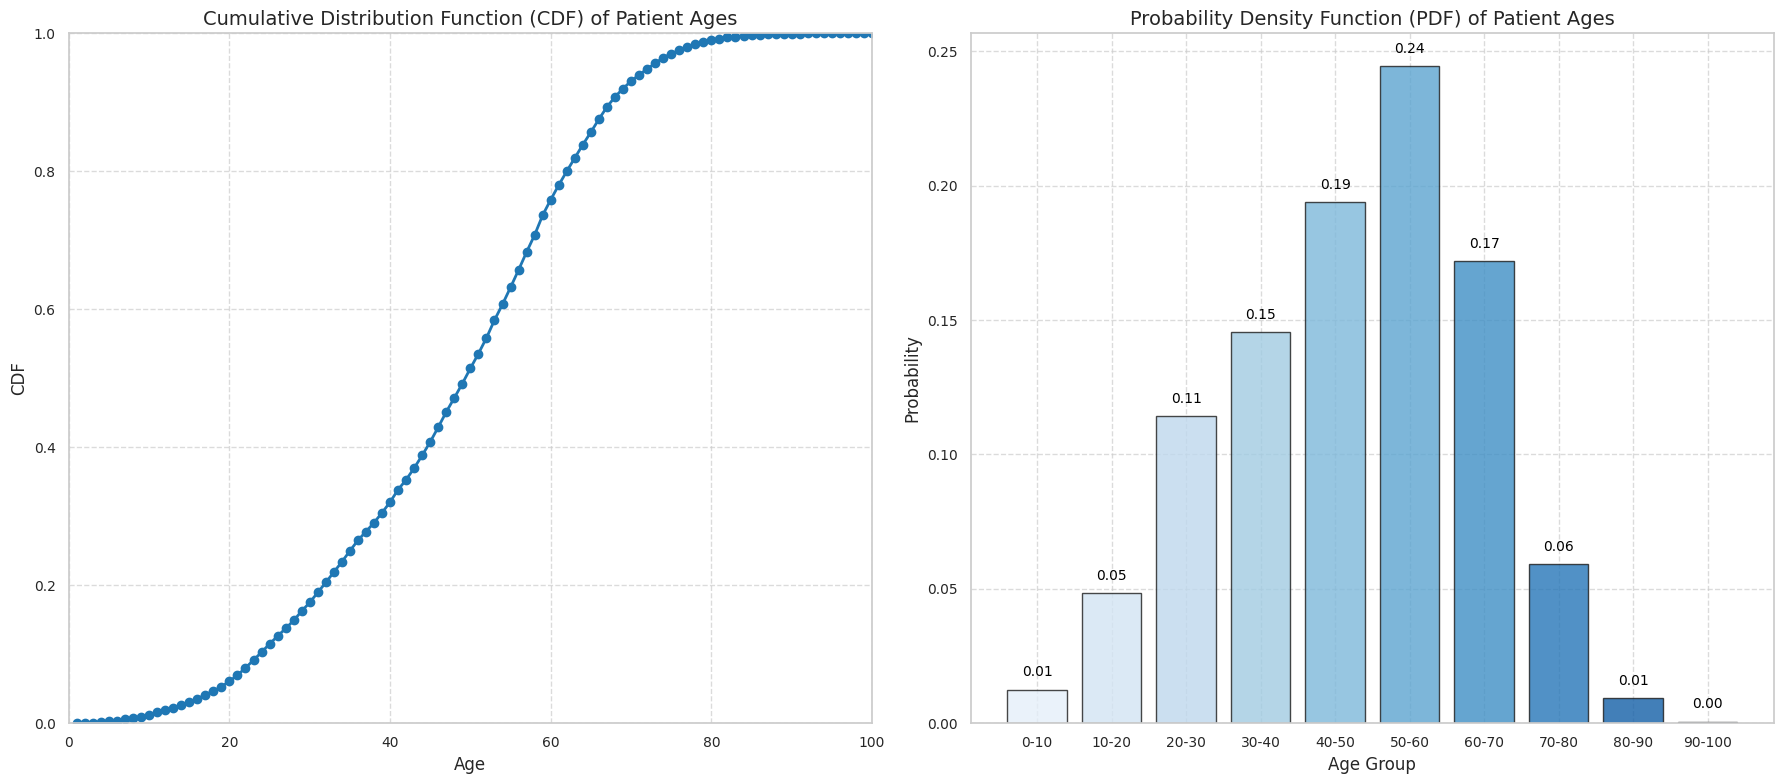

In [70]:
# Extract the 'Patient Age' column
ages = data_entry_df['Patient Age'].dropna()

# Define age bins and labels
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Calculate the cumulative distribution function (CDF)
counts, bin_edges = np.histogram(ages, bins=100, range=(0, 100), density=True)
cdf = np.cumsum(counts) * (bin_edges[1] - bin_edges[0])

# Calculate the probability for each age bin
pdf_counts, _ = np.histogram(ages, bins=age_bins)
pdf_probabilities = pdf_counts / pdf_counts.sum()

# Plot the CDF and PDF
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot the CDF on the first subplot
axes[0].plot(bin_edges[1:], cdf, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('CDF', fontsize=12)
axes[0].set_title('Cumulative Distribution Function (CDF) of Patient Ages', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].grid(visible=True, linestyle='--', alpha=0.7)

# Plot the PDF on the second subplot
colors = sns.color_palette("Blues", len(age_labels))
axes[1].bar(age_labels, pdf_probabilities, width=0.8, color=colors, alpha=0.8, edgecolor='k')
for i, v in enumerate(pdf_probabilities):
    axes[1].text(i, v + 0.005, f'{v:.2f}', ha='center', fontsize=10, color='black')
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Probability Density Function (PDF) of Patient Ages', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].grid(visible=True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()